# S2: MCMTpy Notebook

In this notebook, we will show some **funcs** in **MCMTpy** for Focal Mechanism Inversion Result, including the **conversion of source parameters**, **plot beachball**, **MT decompose** and **plot Huston**. 

Contents:    
* Conversion of source parameters
* Plot beachball
* MT decompose
* Plot Huston



More details on the descriptions of data processing, parameters can be found in the online [documentations](https://github.com/OUCyf) and our paper.

`MCMTpy: A Python Package for Simultaneous Inversion of Source Location, Focal Mechanism, and Rupture Directivity. In prep for Seismological Research Letter.`



Fu Yin

School of Earth and Space Sciences

University of Science and Technology of China

No.96, JinZhai Road Baohe District, Hefei, Anhui, 230026, P.R.China.

June 2021

## Building env for MCMTpy

Before running this notebook, make sure that you have created and activated the conda env made for MCMTpy. If not, you can create one using command lines below ( note that `jupyter` is installed with the command lines here in order to run this notebook). 

```bash
$ conda create -n MCMTpy  python=3.8 numpy=1.16 matplotlib=3.1.1 mpi4py obspy pyasdf json5 tqdm
$ conda activate MCMTpy
$ pip install pyfk
$ pip install MCMTpy
```

Then you need to activate this notebook with the newly built MCMTpy env by invoking the jupyter with the following command line.

```bash
$ jupyter notebook
```

Now we can begin to load the modules needed for this practise.  

- First, let's run the cell below to import packages and the last cell with [helper functions](#helper).
- Back from Helper Function
<a id='helper_back'></a>

In [1]:
import os
import sys
import glob
import obspy
import json5
import pyasdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from obspy import Stream
from obspy.taup import TauPyModel
from obspy.imaging.mopad_wrapper import beach
from MCMTpy import MomentTensor as MTpy

## 1. Conversion of Source Parameters

The **MCMTpy** provides a series of scripts for source parameter calculation and conversion. The MomentTensor script refers to some theories and codes of [Obspy](https://github.com/obspy/obspy)/[MoPaD](https://github.com/geophysics/MoPaD)/Introduction to Seismology (Yongge Wan), mainly including:

    1) The installation
    2) str_dip_rake to mt
    3) The conversion between str_dip_rake and A/N vector
    4) The conversion between A/N vector and P/T/N vector
    5) mt to P/T/N vector
    6) P/T/N vector to P/T/N vector's stirke and dip
    7) Describe_fault_plane with two str_dip_rake

We do not recommend using relative paths because of the possibility of errors. Absolute paths are preferred.

### (a). The installation

In [2]:
# import MomentTensor
from MCMTpy import MomentTensor as MTpy

# get __doc__
MTpy.__doc__.strip().split("\n")

['Created on Sun May 23 19:53:22 2021',
 '@author: Fu Yin (yinfu@mail.ustc.edu.cn) at USTC',
 '',
 'This script refers to some theories and codes of Obspy/MoPaD/Introduction to Seismology (Yongge Wan):',
 '    1) The MoPaD program (https://github.com/geophysics/MoPaD);',
 '    2) str_dip_rake to mt;',
 '    3) The conversion between str_dip_rake and A/N vector;',
 '    4) The conversion between A/N vector and P/T/N vector;',
 '    5) mt to P/T/N vector;',
 "    6) P/T/N vector to P/T/N vector's stirke and dip;",
 '    7) project station to beachball;',
 '    8) Hudson plot',
 '    9) Decompose of mt: isotropic + deviatoric = isotropic + DC + CLVD;',
 '   10) Describe_fault_plane with two str_dip_rake.',
 '',
 'Modify history:',
 '    1) May 23 19:53:22 2021    ||    Fu Yin at USTC    ||    The initial release.',
 '    2) ...']

### (b). str_dip_rake to mt

In [3]:
# function: str_dip_rake2MT

MTpy.str_dip_rake2MT.__doc__.strip().split("\n")

["Input: fault plane' strike dip and rake in degrees.",
 '            strike : [0, 360)',
 '            dip    : [0, 90]',
 '            rake   : [-180, 180)',
 '',
 '    Output: a moment tensor object in NED system.']

In [4]:
# input
strike = 50
dip = 50
rake = 100

A = MTpy.str_dip_rake2MT(strike,dip,rake)
A.mt

array([[-0.43812786,  0.50065515,  0.20274856],
       [ 0.50065515, -0.53171845, -0.02441812],
       [ 0.20274856, -0.02441812,  0.96984631]])

### (c). The conversion between str_dip_rake and A/N vector

In [5]:
# function: str_dip_rake2AN

MTpy.str_dip_rake2AN.__doc__.strip().split("\n")

["Input: fault plane' strike dip and rake in degrees.",
 '            strike : [0, 360)',
 '            dip    : [0, 90]',
 '            rake   : [-180, 180)',
 '',
 "    Output: slip vector(A) and fault plane's normal vector(N) in NED system."]

In [6]:
# str_dip_rake to A/N vector
# input
strike = 50
dip = 50
rake = 100

A,N = MTpy.str_dip_rake2AN(strike,dip,rake)
print('A = ', A)
print('N = ', N)

A =  [ 0.37330426 -0.53992106 -0.75440651]
N =  [-0.58682409  0.49240388 -0.64278761]


In [7]:
# function AN2str_dip_rake

MTpy.AN2str_dip_rake.__doc__.strip().split("\n")

["Input: slip vector(A) and fault plane's normal vector(N) in NED system.",
 '',
 "    Output: fault plane' strike dip and rake.",
 '            strike : [0, 360)',
 '            dip    : [0, 90]',
 '            rake   : [-180, 180)']

In [8]:
# A/N vector to str_dip_rake
# input
A = np.array([0.37330426, -0.53992106, -0.75440651])
N = np.array([-0.58682409,  0.49240388, -0.64278761])

DD = MTpy.AN2str_dip_rake(A,N)
print('strike = ', DD.strike)
print('dip = ', DD.dip)
print('rake = ', DD.rake)

strike =  49.999999855897855
dip =  50.00000010186475
rake =  99.9999997186249


### (d). The conversion between A/N vector and P/T/N vector

In [9]:
# function AN2TPN

MTpy.AN2TPN.__doc__.strip().split("\n")

["Input: slip vector(A) and fault plane's normal vector(N) in NED system.",
 '',
 '    Output: Tension-axis vector(T), Pressure-axis vector(P) and Null-axis ',
 '            vector(Null) in NED system.']

In [10]:
# Calculate the T-axis, P-axis and N-axis according to the slip vector (A) and fault plane direction vector (N)
# input
A = np.array([0.37330426, -0.53992106, -0.75440651])
N = np.array([-0.58682409,  0.49240388, -0.64278761])

T,P,Null = MTpy.AN2TPN(A,N)
print('T = ', T)
print('P = ', P)
print('Null = ', Null)

T =  [-0.15098132 -0.03359972 -0.98796544]
P =  [ 0.67891327 -0.72996397 -0.07892648]
Null =  [ 0.71852726  0.68265927 -0.13302222]


In [11]:
# function TP2AN

MTpy.TP2AN.__doc__.strip().split("\n")

['Input: Tension-axis vector(T) and Pressure-axis vector(P) in NED system.',
 '',
 "    Output: slip vector(A) and fault plane's normal vector(N) in NED system."]

In [12]:
# Calculate the slip vector (A) and fault plane direction vector (N) according to the T-axis and P-axis
# input
T = np.array([-0.15098132, -0.03359972, -0.98796544])
P = np.array([0.67891327, -0.72996397, -0.07892648])

A,N = MTpy.TP2AN(T,P)
print('A = ', A)
print('N = ', N)

A =  [ 0.37330426 -0.53992106 -0.75440651]
N =  [-0.58682409  0.49240388 -0.64278761]


### (e). mt (in NED system) to P/T/N vector

In [13]:
# function MT2TPN

MTpy.MT2TPN.__doc__.strip().split("\n")

['Input: moment tensor in NED system.',
 '',
 '    Output: Tension-axis vector(T), Pressure-axis vector(P) and Null-axis ',
 '            vector(Null) in NED system.']

In [14]:
# input
strike = 50
dip = 50
rake = 100

A = MTpy.str_dip_rake2MT(strike,dip,rake)
T, P, Null = MTpy.MT2TPN(A)
print('T = ', T)
print('P = ', P)
print('Null = ', Null)

T =  [ 0.15098132  0.03359972  0.98796543]
P =  [-0.67891326  0.72996396  0.07892648]
Null =  [ 0.71852726  0.68265926 -0.13302222]


### (f). P/T/N vector to P/T/N vector's stirke and dip

In [15]:
# function vector2str_dip

MTpy.vector2str_dip.__doc__.strip().split("\n")

['Input: a principal axis vector, such as eigenvectors P/T/N of the moment tensor ',
 '            object in NED system.',
 '',
 "    Output: a principal axis' strike and dip.",
 '            strike : [0, 360)',
 '            dip    : [0, 90]']

In [16]:
# input
A = np.array([0.37330426, -0.53992106, -0.75440651])

CC = MTpy.vector2str_dip(A)
print('A.strike = ', CC.strike)
print('A.dip = ', CC.dip)

A.strike =  124.66018574472005
A.dip =  48.973538786656434


### (g). Describe_fault_plane with two str_dip_rake

In [17]:
# function describe_fault_plane

MTpy.describe_fault_plane.__doc__.strip().split("\n")

['Input: moment tensor object in NED system.',
 '',
 '    Output: [strike_1, dip_1, rake_1] and [strike_2, dip_2, rake_2]']

In [18]:
# input
strike = 50
dip = 50
rake = 100

A = MTpy.str_dip_rake2MT(strike,dip,rake)
CC = MTpy.describe_fault_plane(A.mt)
print('FM_1 = ', CC[0,:])
print('FM_2 = ', CC[1,:])

FM_1 =  [  50.   50.  100.]
FM_2 =  [ 214.6601855    41.02646137   78.30792279]


## 2. Plot beachball

- The **MCMTpy** provides a series of scripts to plot results.

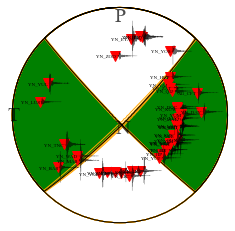

In [31]:
## 0. set path
example_path = '/Users/yf/3.Project/8.MCMTpy/MCMTpy-master/data/example_yunnan'
FM_path=os.path.join(example_path,"YN.202105212148_Inv/dc_inv/Output_YN.202105212148_dc/rank_0_output/chain_0_FM_accept_all")
allfiles_path = os.path.join(example_path,'YN.202105212148_Inv/YN.202105212148_raw/*.SAC') 
 

## 1. read FM
N=3 # Three parameters are required to describe the focal mechanism
FM_all = np.loadtxt(FM_path)
FM_raw = FM_all[0:,1:N+1] # Define the number of solutions you want to plot
strike_np = FM_raw[:,0]
dip_np = FM_raw[:,1]
rake_np = FM_raw[:,2]
FM = np.vstack((strike_np, dip_np,  rake_np)).T
FM_mean=np.zeros(shape=(N))
for i in range(0,N,1):
    FM_mean[i]=np.mean(FM[0:,i])


## 2.read raw data
data = read_data(allfiles_path)
data.filter('bandpass', freqmin=0.005, freqmax=0.5, corners=4, zerophase=True)


## 3.ray trace with taup
model_path = os.path.join(example_path,"v_model/v_model.npz") 
model = TauPyModel(model=model_path)    # "iasp91"  "prem"
for i in range(0,len(data),1):
    depth = data[i].stats.sac['evdp']
    distance = data[i].stats.sac['dist']
    ray_p,tp,angle_p,ray_s,ts,angle_s = get_taup_tp_ts(model,depth,distance,degree=False)                                            
    data[i].stats.sac["user1"]=angle_p
    data[i].stats.sac["user2"]=angle_s



## 4.1 plot FM_mean
ax0 = plt.gca()
Length_Ball = 100
beach1 = beach(FM_mean, xy=(50, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
               facecolor='g',bgcolor='w', edgecolor='k',mopad_basis='NED',nofill=False,zorder=1 )
ax0.add_collection(beach1) 
ax0.set_aspect("equal")


## 4.2 plot FM_all
for i in range(0,FM.shape[0],1):
    beach1 = beach(FM[i,:], xy=(50, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
                facecolor='b',bgcolor='w', edgecolor='orange',mopad_basis='NED',nofill=True,zorder=1 )
    ax0.add_collection(beach1) 
    ax0.set_aspect("equal")


## 4.3 plot backgroud line
beach1 = beach(FM_mean, xy=(50, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
                facecolor='w',bgcolor='w', edgecolor='k',mopad_basis='NED',nofill=True,zorder=1 )
ax0.add_collection(beach1) 
ax0.set_aspect("equal")



## 5.plot station and waveform
menthod='schmidt'   # 'schmidt' 'wulff'
for i in range(0,len(data),3):
    AZM = data[i].stats.sac['az'] 
    TKO = data[i].stats.sac['user1']
    net_sta_name = data[i].stats.network+'_'+data[i].stats.station    
    X, Y = MTpy.project_beachball(AZM, TKO, R=Length_Ball/2, menthod=menthod)    
    tt=np.linspace(X, X+10, num=len(data[i].data)) 
    ax0.plot(X, Y, "rv", ms=10,zorder=1) 
    ax0.plot(tt, 5*data[i].data/2000000 + Y,  color='black',lw=0.2,alpha=0.6,zorder=1)
    ax0.text(X, Y,net_sta_name,horizontalalignment='right', verticalalignment='center',\
          fontsize=5, color='black',bbox = dict(facecolor = "r", alpha = 0.0),zorder=1) 


## 6. plot P/T/N axis
MT = MTpy.str_dip_rake2MT(strike=FM_mean[0],dip=FM_mean[1],rake=FM_mean[2])
T_axis, P_axis, N_axis = MTpy.MT2TPN(MT)
T = MTpy.vector2str_dip(T_axis)
P = MTpy.vector2str_dip(P_axis)
N = MTpy.vector2str_dip(N_axis)

Tx, Ty = MTpy.project_beachball(AZM=T.strike, TKO=(90-T.dip), R=Length_Ball/2, menthod=menthod)
ax0.text(Tx,Ty,'T',horizontalalignment='center', verticalalignment='center',\
          fontsize=20, color='k',alpha=0.7,zorder=1) 

Px, Py = MTpy.project_beachball(AZM=P.strike, TKO=(90-P.dip), R=Length_Ball/2, menthod=menthod)
ax0.text(Px,Py,'P',horizontalalignment='center', verticalalignment='center',\
          fontsize=20, color='k',alpha=0.7,zorder=1) 

Nx, Ny = MTpy.project_beachball(AZM=N.strike, TKO=(90-N.dip), R=Length_Ball/2, menthod=menthod)
ax0.text(Nx,Ny,'N',horizontalalignment='center', verticalalignment='center',\
          fontsize=20, color='k',alpha=0.7,zorder=1) 


## 7. save figure
ax0.set_xlim(0,100)
ax0.set_ylim(0,100)
ax0.set_axis_off() 
figurename=os.path.join('./S2_figure/beachball.pdf')
plt.savefig(figurename,dpi=800, format="pdf")

## 3. MT decompose

In [29]:
# [Mxx_np,  Myy_np,  Mzz_np,  Mxy_np,  Mxz_np,  Myz_np] or [strike,dip,rake]
FM=[150,50,100]


# 分解矩张量
MT = MTpy.MTensor(FM)
Dec = MTpy.Decompose(MT)
Dec.decomposition_iso_DC_CLVD()   # Dec.help()
print(Dec.help())
print('\n\n*********************************\n\n')
Dec.print_self()

Mxx = Dec.M_iso[0,0]
Mxy = Dec.M_iso[0,1]
Mxz = Dec.M_iso[0,2]
Myy = Dec.M_iso[1,1]
Myz = Dec.M_iso[1,2]
Mzz = Dec.M_iso[2,2]
FM_iso = np.array((Mxx,  Myy,  Mzz,  Mxy,  Mxz,  Myz))

Mxx = Dec.M_DC[0,0]
Mxy = Dec.M_DC[0,1]
Mxz = Dec.M_DC[0,2]
Myy = Dec.M_DC[1,1]
Myz = Dec.M_DC[1,2]
Mzz = Dec.M_DC[2,2]
FM_DC = np.array((Mxx,  Myy,  Mzz,  Mxy,  Mxz,  Myz))

Mxx = Dec.M_CLVD[0,0]
Mxy = Dec.M_CLVD[0,1]
Mxz = Dec.M_CLVD[0,2]
Myy = Dec.M_CLVD[1,1]
Myz = Dec.M_CLVD[1,2]
Mzz = Dec.M_CLVD[2,2]
FM_CLVD = np.array((Mxx,  Myy,  Mzz,  Mxy,  Mxz,  Myz))

Incluing function:
self.M
self.M_iso
self.M_devi
self.M_DC
self.M_CLVD
self.M0
self.Mw
self.M_iso_percentage
self.M_DC_percentage
self.M_CLVD_percentage
self.eigen_val
self.eigen_vec
self.F
None


*********************************


self.M: [[-0.3576622  -0.48646688 -0.01115976]
 [-0.48646688 -0.61218411  0.20390851]
 [-0.01115976  0.20390851  0.96984631]] 

self.M_iso: [[ -3.70074342e-17   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -3.70074342e-17   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -3.70074342e-17]] 

self.M_devi: [[-0.3576622  -0.48646688 -0.01115976]
 [-0.48646688 -0.61218411  0.20390851]
 [-0.01115976  0.20390851  0.96984631]] 

self.M_DC: [[-0.3576622  -0.48646688 -0.01115976]
 [-0.48646688 -0.61218411  0.20390851]
 [-0.01115976  0.20390851  0.96984631]] 

self.M_CLVD: [[  3.33066907e-16   1.66533454e-16  -2.77555756e-17]
 [  1.66533454e-16  -2.22044605e-16   5.55111512e-17]
 [ -2.77555756e-17   5.55111512e-17   0.00000000e+00]] 

self.M0: 1.0 

self.

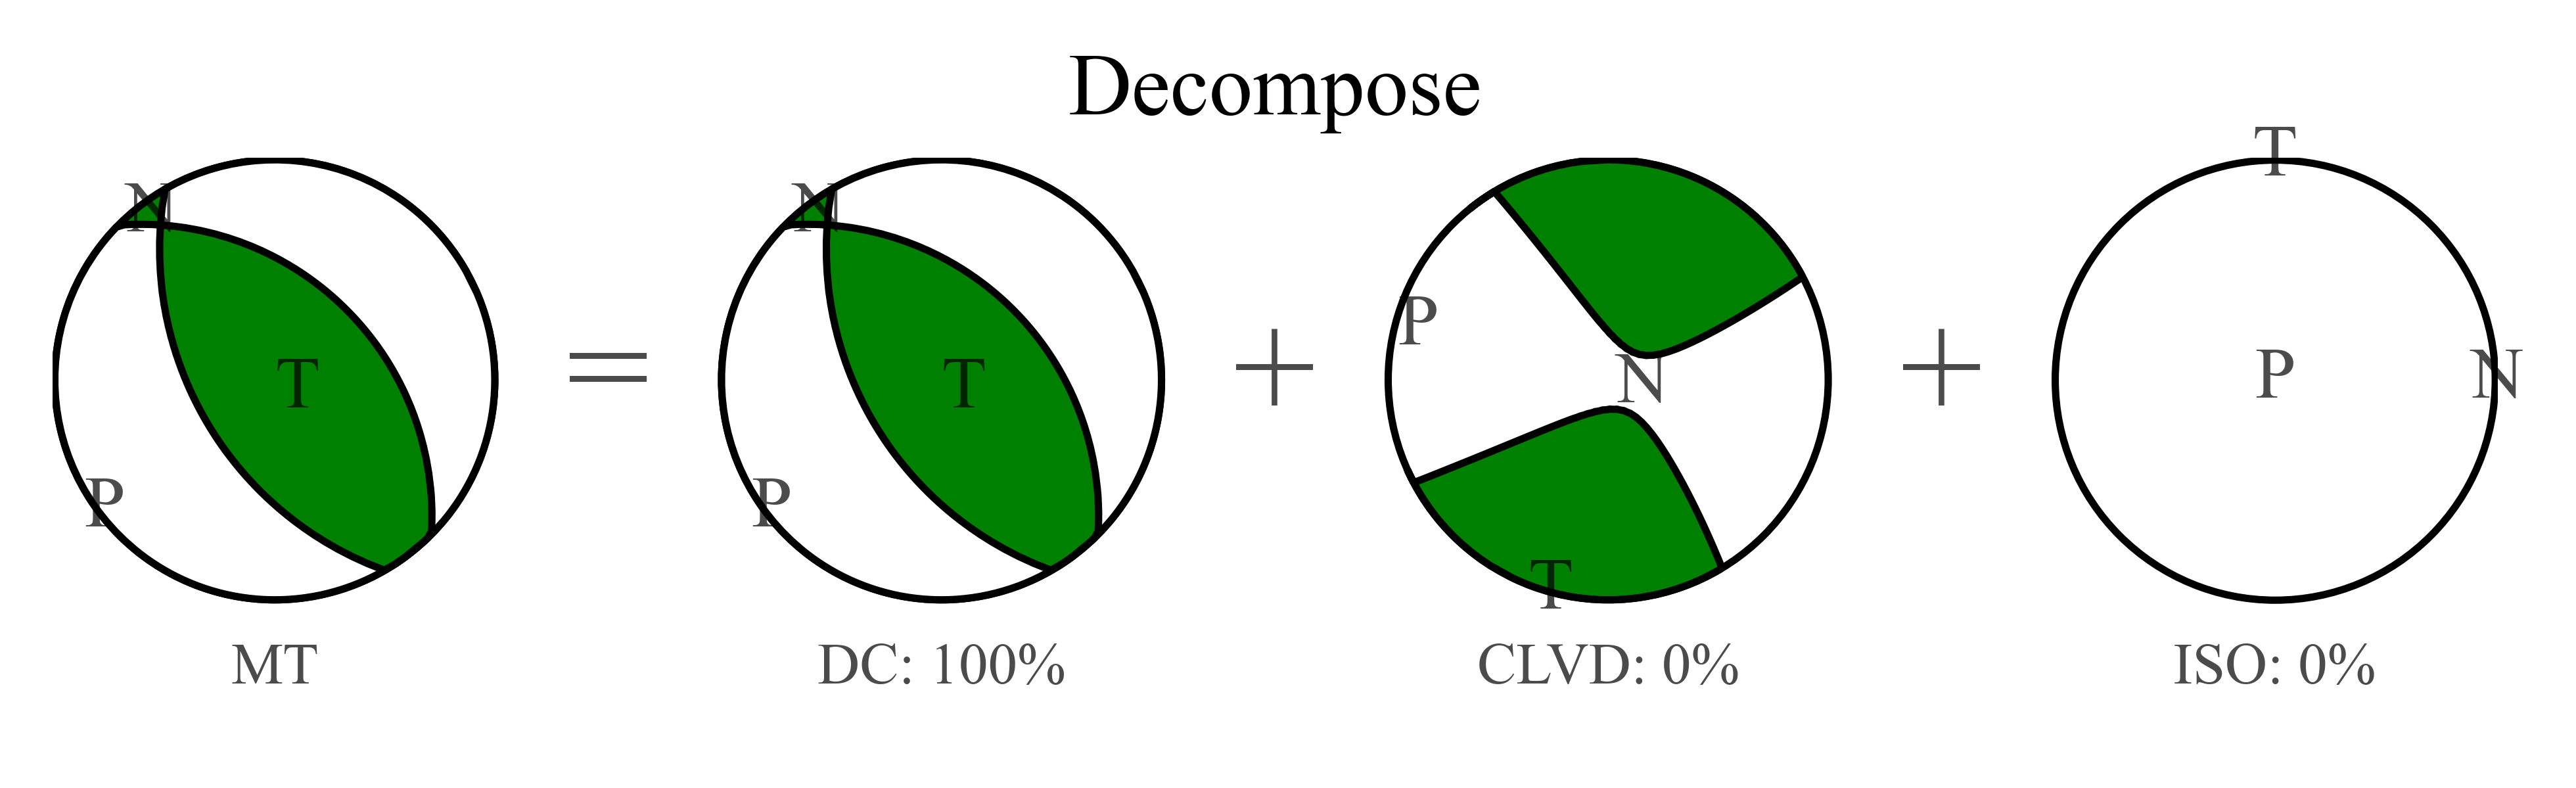

In [30]:
fig = plot_decompose(FM, FM_DC, FM_CLVD, FM_iso)
figurename=os.path.join('./S2_figure/Decompose.pdf')
plt.savefig(figurename,dpi=800, format="pdf")

## 4. Plot Huston

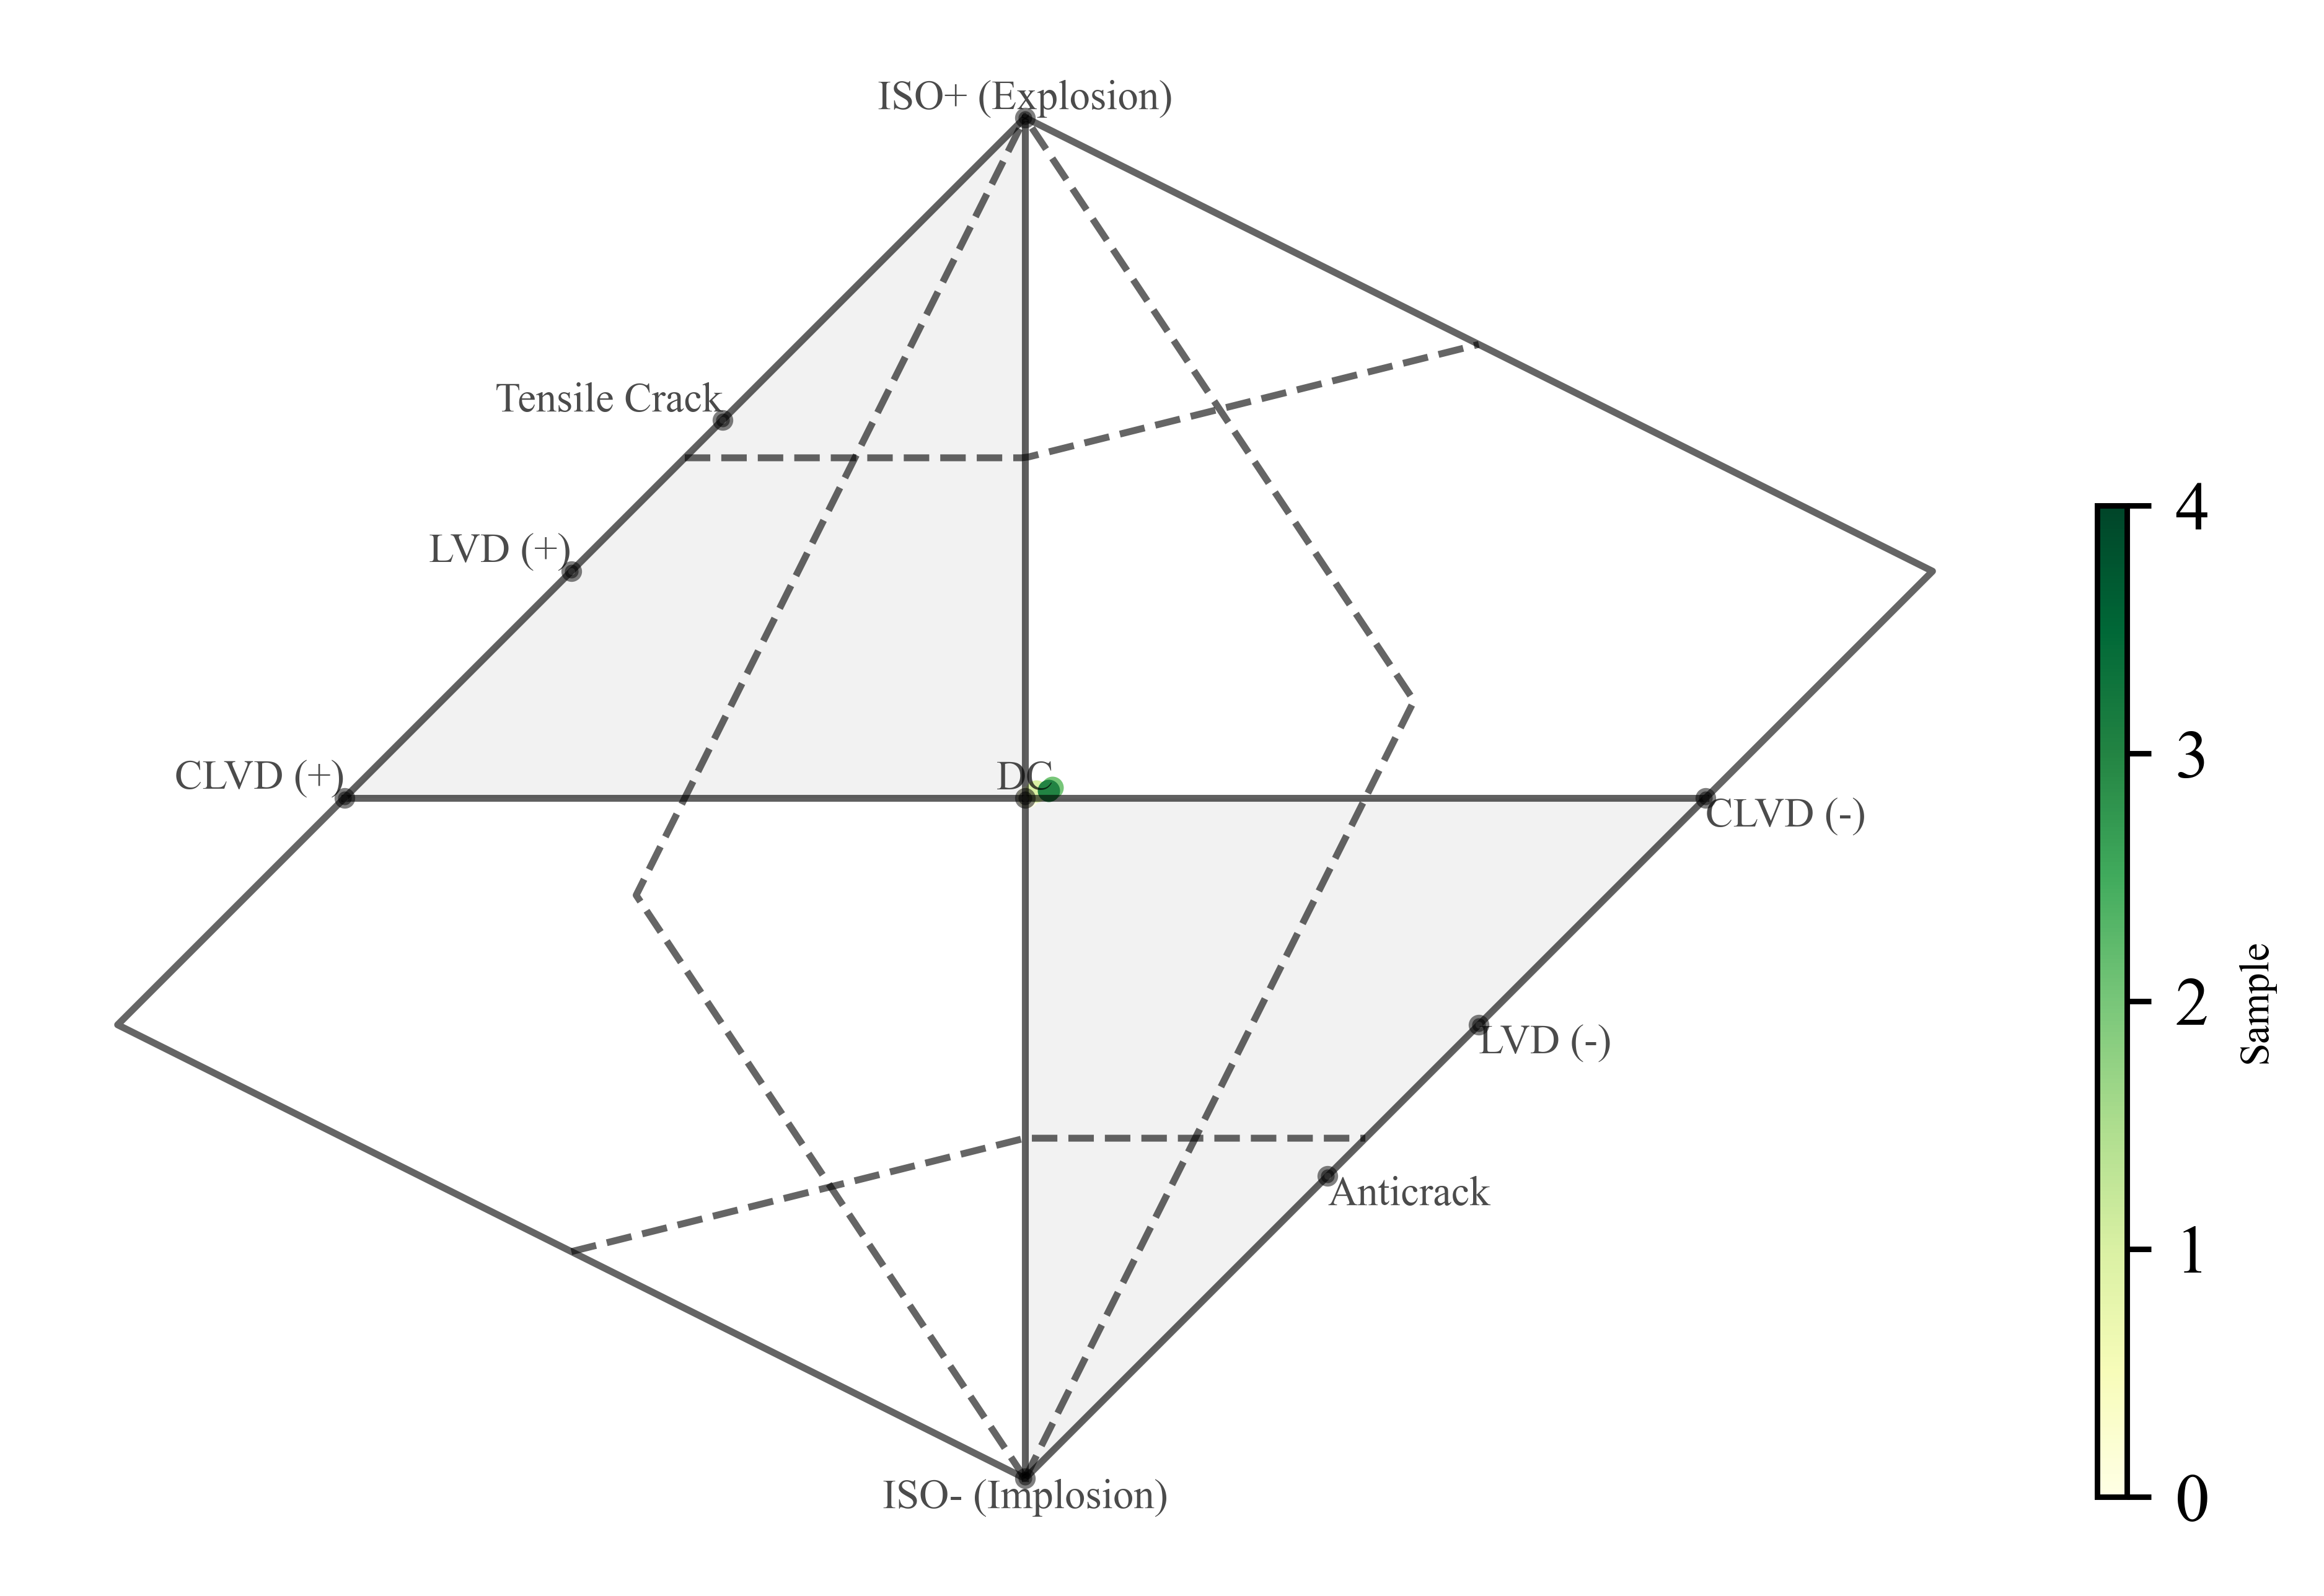

In [27]:
## 0. set path
example_path = '/Users/yf/3.Project/8.MCMTpy/MCMTpy-master/data/example_yunnan'
FM_path=os.path.join(example_path,"YN.202105212148_Inv/mt_inv/Output_YN.202105212148_mt/rank_0_output/chain_0_FM_accept_all")
allfiles_path = os.path.join(example_path,'YN.202105212148_Inv/YN.202105212148_raw/*.SAC') 
 

## 1. read FM
N=6
FM_all = np.loadtxt(FM_path)
FM_raw = FM_all[0:,1:N+1]
Mxx_np = FM_raw[:,0]
Mxy_np = FM_raw[:,1]
Mxz_np = FM_raw[:,2]
Myy_np = FM_raw[:,3]
Myz_np = FM_raw[:,4]
Mzz_np = FM_raw[:,5]
FM = np.vstack((Mxx_np,  Myy_np,  Mzz_np,  Mxy_np,  Mxz_np,  Myz_np)).T

## 2. plot Hudson
fig = plot_Hudson_points(FM)
figurename=os.path.join('./S2_figure/Hudson.pdf')
plt.savefig(figurename,dpi=800, format="pdf")

## The end.

We hope you enjoy it! 

Most of the core steps of MCMTpy are included here.

# Helper function
<a id='helper'></a>

In [25]:
#***************************************************************
#*                       -----------
#*                        Functions
#*                       -----------
#***************************************************************
# The notobook needs some functions, please run it firstly:

#----------------------------------------------------#
#%% 1.read raw data
def read_data(allfiles_path):

    allfiles = sorted( glob.glob(allfiles_path) )
    data_raw = Stream()
    for i in range(0,len(allfiles),1):
        try:
            tr = obspy.read(allfiles[i])
            data_raw += tr
        except Exception:
            print(allfiles[i],': no such file or obspy read error');continue
    data = data_raw.copy()
    
    return data




#----------------------------------------------------#
#%% 2.taup ray trace
def get_taup_tp_ts(model,depth,distance,degree=None):
    if degree==False:
        distance = distance/111.19

    time_p = model.get_travel_times(source_depth_in_km=depth,
                                    distance_in_degree=distance,
                                    phase_list=["p", "P"])

    time_s = model.get_travel_times(source_depth_in_km=depth,
                                    distance_in_degree=distance,
                                    phase_list=["s", "S"])

    ray_p = time_p[0].ray_param
    tp = time_p[0].time
    angle_p = time_p[0].incident_angle

    ray_s = time_s[0].ray_param
    ts = time_s[0].time
    angle_s = time_s[0].incident_angle

    return ray_p,tp,angle_p,ray_s,ts,angle_s



#----------------------------------------------------#
#%% 3.plot decompose mt
def plot_decompose(FM,FM_DC,FM_CLVD,FM_iso):
    MT = MTpy.MTensor(FM)
    Dec = MTpy.Decompose(MT)
    Dec.decomposition_iso_DC_CLVD()
    
    fig2, ax2 = plt.subplots(1 ,1,  dpi=800)
    Length_Ball = 100

    ###### MT
    beach1 = beach(FM, xy=(50, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
                   facecolor='g',bgcolor='w', edgecolor='k',mopad_basis='NED',nofill=False,zorder=1 )
    ax2.add_collection(beach1) 
    ax2.set_aspect("equal")

    menthod='schmidt'   # 'schmidt'  # 'wulff'
    T_axis, P_axis, N_axis = MTpy.MT2TPN(MTpy.MTensor(FM))
    T = MTpy.vector2str_dip(T_axis)
    P = MTpy.vector2str_dip(P_axis)
    N = MTpy.vector2str_dip(N_axis)

    Tx, Ty = MTpy.project_beachball(AZM=T.strike, TKO=(90-T.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(Tx,Ty,'T',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Px, Py = MTpy.project_beachball(AZM=P.strike, TKO=(90-P.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(Px,Py,'P',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Nx, Ny = MTpy.project_beachball(AZM=N.strike, TKO=(90-N.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(Nx,Ny,'N',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 



    ###### DC
    beach2 = beach(FM_DC, xy=(200, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
                   facecolor='g',bgcolor='w', edgecolor='k',mopad_basis='NED',nofill=False,zorder=1 )
    ax2.add_collection(beach2) 
    ax2.set_aspect("equal")

    menthod='schmidt'   # 'schmidt'  # 'wulff'
    T_axis, P_axis, N_axis = MTpy.MT2TPN(MTpy.MTensor(FM_DC))
    T = MTpy.vector2str_dip(T_axis)
    P = MTpy.vector2str_dip(P_axis)
    N = MTpy.vector2str_dip(N_axis)

    Tx, Ty = MTpy.project_beachball(AZM=T.strike, TKO=(90-T.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*1+Tx,Ty,'T',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Px, Py = MTpy.project_beachball(AZM=P.strike, TKO=(90-P.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*1+Px,Py,'P',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Nx, Ny = MTpy.project_beachball(AZM=N.strike, TKO=(90-N.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*1+Nx,Ny,'N',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    ####### CLVD
    beach3 = beach(FM_CLVD, xy=(350, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
                   facecolor='g',bgcolor='w', edgecolor='k',mopad_basis='NED',nofill=False,zorder=1 )
    ax2.add_collection(beach3) 
    ax2.set_aspect("equal")

    menthod='schmidt'   # 'schmidt'  # 'wulff'
    T_axis, P_axis, N_axis = MTpy.MT2TPN(MTpy.MTensor(FM_CLVD))
    T = MTpy.vector2str_dip(T_axis)
    P = MTpy.vector2str_dip(P_axis)
    N = MTpy.vector2str_dip(N_axis)

    Tx, Ty = MTpy.project_beachball(AZM=T.strike, TKO=(90-T.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*2+Tx,Ty,'T',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Px, Py = MTpy.project_beachball(AZM=P.strike, TKO=(90-P.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*2+Px,Py,'P',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Nx, Ny = MTpy.project_beachball(AZM=N.strike, TKO=(90-N.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*2+Nx,Ny,'N',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 


    ####### iso
    beach4 = beach(FM_iso, xy=(500, 50),  linewidth=1,width=Length_Ball-1, alpha=1,\
                   facecolor='g',bgcolor='w', edgecolor='k',mopad_basis='NED',nofill=False,zorder=1 )
    ax2.add_collection(beach4) 
    ax2.set_aspect("equal")

    menthod='schmidt'   # 'schmidt'  # 'wulff'
    T_axis, P_axis, N_axis = MTpy.MT2TPN(MTpy.MTensor(FM_iso))
    T = MTpy.vector2str_dip(T_axis)
    P = MTpy.vector2str_dip(P_axis)
    N = MTpy.vector2str_dip(N_axis)

    Tx, Ty = MTpy.project_beachball(AZM=T.strike, TKO=(90-T.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*3+Tx,Ty,'T',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Px, Py = MTpy.project_beachball(AZM=P.strike, TKO=(90-P.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*3+Px,Py,'P',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1) 

    Nx, Ny = MTpy.project_beachball(AZM=N.strike, TKO=(90-N.dip), R=Length_Ball/2, menthod=menthod)
    ax2.text(150*3+Nx,Ny,'N',horizontalalignment='center', verticalalignment='center',\
              fontsize=10, color='k',alpha=0.7,zorder=1)

    ####### plot '+' and '='
    ax2.text(125,50,'=',horizontalalignment='center', verticalalignment='center',\
              fontsize=20, color='k',alpha=0.7,zorder=1)
    ax2.text(275,50,'+',horizontalalignment='center', verticalalignment='center',\
              fontsize=20, color='k',alpha=0.7,zorder=1)
    ax2.text(425,50,'+',horizontalalignment='center', verticalalignment='center',\
              fontsize=20, color='k',alpha=0.7,zorder=1)
    
    
    ####### plot percentage
    MT_text = 'MT'
    ax2.text(50,-15,MT_text,horizontalalignment='center', verticalalignment='center',\
              fontsize=8, color='k',alpha=0.7,zorder=1)
    
    iso_text = 'ISO: '+str(round(Dec.M_iso_percentage,2))+'%'
    ax2.text(500,-15,iso_text,horizontalalignment='center', verticalalignment='center',\
              fontsize=8, color='k',alpha=0.7,zorder=1)
    
    DC_text = 'DC: '+str(round(Dec.M_DC_percentage,2))+'%'
    ax2.text(200,-15,DC_text,horizontalalignment='center', verticalalignment='center',\
              fontsize=8, color='k',alpha=0.7,zorder=1)
    
    CLVD_text = 'CLVD: '+str(round(Dec.M_CLVD_percentage,2))+'%'
    ax2.text(350,-15,CLVD_text,horizontalalignment='center', verticalalignment='center',\
              fontsize=8, color='k',alpha=0.7,zorder=1)


    ####### set figure
    plt.title("Decompose")
    ax2.set_xlim(0,550)
    ax2.set_ylim(-30,100)
    ax2.set_axis_off() 

    return fig2




#----------------------------------------------------#
#%% 4. plot_Hudson_points
def plot_Hudson_points(FM):
    fig1, ax1 = plt.subplots(1 ,1,  dpi=800)
    plt.rc('font',family='Times New Roman')
    MTpy.Hudson_plot(ax=ax1)
    for i in range(0,len(FM)): 
        MT = MTpy.MTensor(FM[i,:])
        M=MT.mt

        k,T = MTpy.M2kT_space(M)
        U,V = MTpy.kT2UV_space(k,T)
    
        map_vir = cm.get_cmap(name='YlGn')
        colors = map_vir(i/len(FM))
    
        ax1.scatter(U,V, color=colors,marker='o', s=5)


    position=fig1.add_axes([0.85, 0.15, 0.01, 0.5])
    font_colorbar = {'family' : 'Times New Roman',
            'color'  : 'black',
            'weight' : 'normal',
            'size'   : 6,
            }
    sm = cm.ScalarMappable(cmap=map_vir)               
    sm.set_array(np.arange(0,len(FM)+1))    
    cb=plt.colorbar(sm,cax=position,orientation='vertical') 
    cb.set_label('Sample',fontdict=font_colorbar)

    ax1.set_xlim(-4/3-0.1, 4/3+0.3)
    ax1.set_ylim(-1-0.1, 1+0.1)
    
    
    ## 2. save figure
    #plt.title("hudson_plot")
    # figurename=os.path.join('./Hudson_plot.pdf')
    # plt.savefig(figurename,dpi=800, format="pdf")

    return fig1

-[Turn back!](#helper_back)